In [1]:
!pip install torchinfo

In [18]:
import os
import gc

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
import torchvision.models as models
from torchinfo import summary

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
!bash get_data.sh

kagglecatsanddogs_3 100%[===================>] 786.68M   122MB/s    in 7.9s    
Downloading...
From: https://drive.google.com/u/0/uc?id=10NIeg2v6b9SzBBkqzbxUT_xTTgzIjsmv
To: /content/Dataset/101_ObjectCategories.tar.gz
132MB [00:02, 65.1MB/s]
Unziping... OK


## Utils

In [14]:
def save_model(path, model):
    example = torch.rand(1, 3, 224, 224)
    traced_script_module = torch.jit.trace(model.cpu(), example)
    traced_script_module.save(path+"_trace")
    torch.save(model, path+"_torch")

## Training
This cell uses starter code from University of Wrocław Neural Network Course - [Assignment 3](https://github.com/janchorowski/dl_uwr)

In [15]:
def compute_error_rate(model, data_loader, cuda=True):
    model.eval()
    num_errs = 0.0
    num_examples = 0
    pred_fun = nn.Sigmoid()
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()

        with torch.no_grad():
            outputs = model.forward(x).view(-1)
            predictions = pred_fun(outputs) > 0.5
            num_errs += (predictions != y).sum().item()
            num_examples += x.size(0)
    return 100.0 * num_errs / num_examples


def train(
    model, 
    data_loaders, 
    optimizer, 
    criterion, 
    num_epochs=1, 
    log_every=100, 
    cuda=True,
    verbose=True):

    if cuda:
        model.cuda()

    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    pred_fun = nn.Sigmoid()

    if verbose:
        print("Training the model!")
        print("You can interrupt it at any time.")
    try:
        while epoch < num_epochs:
            model.train()
            gc.collect()
            epoch += 1

            for x, y in data_loaders["train"]:

                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                iter_ += 1
                optimizer.zero_grad()
                out = model(x).view(-1)

                loss = criterion(out, y.float())
                loss.backward()
                optimizer.step()
                predictions = pred_fun(out) > 0.5
                err_rate = 100.0 * (predictions != y).sum() / y.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(err_rate.item())

                                
                if iter_ % log_every == 0 and verbose:
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%".format(
                            iter_, loss.item(), err_rate
                        )
                    )

            val_err_rate = compute_error_rate(model, data_loaders["val"], cuda)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
        
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
                
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate, num_epochs
            )
            if verbose:
                print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass
    if best_params is not None and verbose:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    if verbose:
       plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    legend()

    subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    ylim(0, 20)
    legend()

# Dataset

In [20]:
class Subset(Dataset):
    r"""
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        im, labels = self.dataset[self.indices[idx]]
        return self.transform(im), labels

    def __len__(self):
        return len(self.indices)

### Cats from catsvsdogs kaggledataset for Cat images and CalltechDataset for NonCats images

In [21]:
path = '/content/Dataset'
caltech_and_cats = datasets.ImageFolder(path)
print(f"Dataset Size: {len(caltech_and_cats)}")
print(f"Dataset Classes: {caltech_and_cats.classes}")
print(f"Number of Cats: {sum(np.array(caltech_and_cats.targets)==0)}")
print(f"Number of NonCats: {sum(np.array(caltech_and_cats.targets)==1)}")
assert len(caltech_and_cats.classes) == 2, "if not restart notebook"

Dataset Size: 21643
Dataset Classes: ['Cats', 'NonCats']
Number of Cats: 12499
Number of NonCats: 9144


### Standard Imagenet Transforms ( We are using model pretrained on imagenet)

In [22]:
image_net_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )

### Dataset split 80-10-10

In [23]:
all_indexes = np.random.permutation(len(caltech_and_cats))
idxs = len(all_indexes)
train_indexes = all_indexes[:int(idxs * 0.8)]
val_indexes = all_indexes[int(idxs * 0.8):int(idxs*0.9)]
test_indexes = all_indexes[int(idxs * 0.9):]

# Train/Test Loaders

In [25]:
train_dataset = Subset(
    caltech_and_cats,
    train_indexes,
    image_net_transforms
)


test_dataset = Subset(
    caltech_and_cats,
    val_indexes,
    image_net_transforms
)

test_dataset = Subset(
    caltech_and_cats,
    test_indexes,
    image_net_transforms
)


datasets_ = {
    "train": train_dataset,
    "val": train_dataset,
    "test": train_dataset,
}


batch_size = 64

train_data_loaders = {
    "train": torch.utils.data.DataLoader(
        datasets_["train"], batch_size=batch_size, num_workers=2, shuffle=True),
    "val": torch.utils.data.DataLoader(
        datasets_["val"], batch_size=batch_size, num_workers=2, shuffle=False)}

test_data_loader = {
    "test": torch.utils.data.DataLoader(
        datasets_["test"], batch_size=batch_size, num_workers=2, shuffle=False)}

## Plain Pretrained Models

## MobileNet - Small

In [26]:
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


In [27]:
for p in mobilenet_v3_small.parameters():
    p.requires_grad = False

model = nn.Sequential(mobilenet_v3_small.features, 
                            nn.AdaptiveAvgPool2d(output_size=1),
                            nn.Flatten(),
                            nn.Linear(576,1))

criterion = (torch.nn.BCEWithLogitsLoss())

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [28]:
summary(model.cpu(), input_size=(1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    --                        --
├─Sequential: 1-1                             [1, 576, 7, 7]            --
│    └─ConvBNActivation: 2-1                  [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 16, 112, 112]         (432)
│    │    └─BatchNorm2d: 3-2                  [1, 16, 112, 112]         (32)
│    │    └─Hardswish: 3-3                    [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                  [1, 16, 56, 56]           --
│    │    └─Sequential: 3-4                   [1, 16, 56, 56]           (744)
│    └─InvertedResidual: 2-3                  [1, 24, 28, 28]           --
│    │    └─Sequential: 3-5                   [1, 24, 28, 28]           (3,864)
│    └─InvertedResidual: 2-4                  [1, 24, 28, 28]           --
│    │    └─Sequential: 3-6                   [1, 24, 28, 28]           (5,416)
│ 

Training the model!
You can interrupt it at any time.
Minibatch    100  | loss  0.55 | err rate 31.25%
Minibatch    200  | loss  0.48 | err rate 17.19%
----------------------------------------------------------
After epoch  1 | valid err rate:  7.51% | doing   5 epochs
----------------------------------------------------------
Minibatch    300  | loss  0.36 | err rate  6.25%
Minibatch    400  | loss  0.32 | err rate  4.69%
Minibatch    500  | loss  0.27 | err rate  3.12%
----------------------------------------------------------
After epoch  2 | valid err rate:  3.97% | doing   5 epochs
----------------------------------------------------------
Minibatch    600  | loss  0.26 | err rate  3.12%
Minibatch    700  | loss  0.25 | err rate  3.12%
Minibatch    800  | loss  0.16 | err rate  0.00%
----------------------------------------------------------
After epoch  3 | valid err rate:  3.21% | doing   5 epochs
----------------------------------------------------------
Minibatch   1000  | los

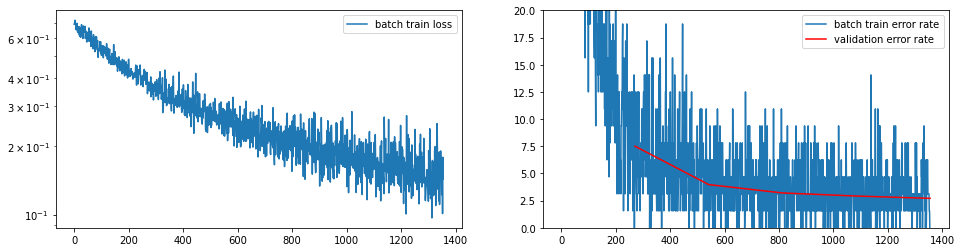

In [29]:
train(
    model, 
    train_data_loaders, 
    optimizer, 
    criterion, 
    num_epochs=5, 
    log_every=100, 
    cuda=True,
    verbose=True)

In [30]:
save_model('MobileNetV3_small', model)